### Import Prerequisite Libraries

In [1]:
import os
import tensorflow as tf
import numpy as np
import pandas as pd
import keras.layers as layers
import cv2
import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from skimage.transform import resize
from tqdm import tqdm
import seaborn as sns
from sklearn.metrics import confusion_matrix

### Define key variables

In [2]:
filepath = 'data'
test_size = 0.2
dev_size = 0.2
height = 102
width = 136
epochs = 30
learning_rate=0.0005
random.seed(6278)

### Import Data
Using the cv2 package, read in each file and append it to a normal list to create X data. For each file being read append the folder name which specifies the shoe_type label to Y variable.

As experienced later in development, not all images are of the specified 136x102 pixels so, in reading in the images, all will be resized with skimage to these dimensions such that they are of equal size later.

In [3]:
X = []
Y = []

for shoe_folder in os.scandir(filepath): # iterate through subfolders
    shoe_type = os.path.basename(shoe_folder) # Save folder name string for use as shoe label
    pbar = tqdm(os.scandir(shoe_folder.path), total=5000) # Use tqdm iter to display progress of reading in images
    
    for file in pbar: # iterate through files
        pbar.set_description(f"Processing {shoe_type} Images")
        img = cv2.imread(file.path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # transform defualt read in of cv2 BGR to RGB
        img_array = np.asarray(img)
        
        if img_array.shape != (102,136,3): # Do conditional resizing to save computing power
            img_array = resize(img_array, [height,width], anti_aliasing=True) # resize to ensure all images are 136 x 102
            
        X.append(img_array)
        Y.append(shoe_type)

Processing Shoe Images: 100%|██████████| 5000/5000 [00:02<00:00, 1761.54it/s]


In [4]:
X_Y = list(zip(X,Y)) # Zip images and associated label
random.shuffle(X_Y) # Shuffle
X, Y = zip(*X_Y) # Unzip back into X and Y

### Visualize shuffled images
Lets take a look at the first 20 images in the shuffled data. Their Y label is used as the subplot title

C:\Users\user\AppData\Local\Temp\ipykernel_17132\2928375289.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


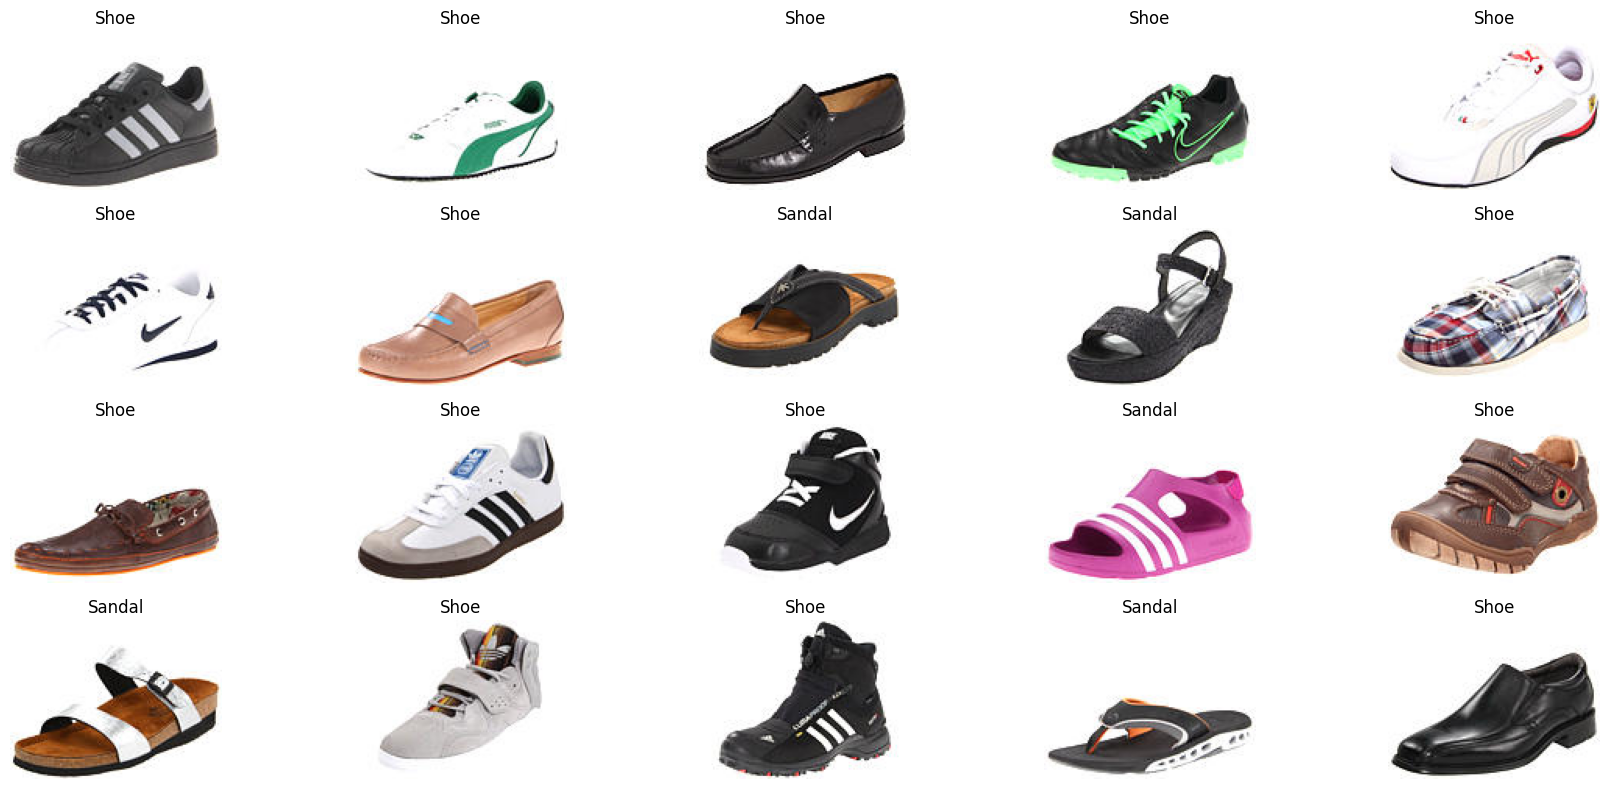

In [5]:
fig, axs = plt.subplots(4,5, figsize=[18,8])
for i in range(20):
    ax = axs[i//5, i%5]
    ax.imshow(X[i])
    ax.axis('off')
    ax.set_title(Y[i])
    
fig.tight_layout()
fig.show()

### Split Data into Train-Dev-Test
Steps:

- Convert list of nparray into singular nparrays
- One-Hot Encode Y-label
- Split into Train-Dev-Test
- Delete unused arrays to save on memory

In [6]:
num_dev = int(len(X) * dev_size) 
num_test = int(len(X) * test_size)

X_arr = np.asarray(X) / 255
Y_arr = np.asarray(Y).reshape(-1,1)

del X, Y

ohe = OneHotEncoder(categories='auto', sparse_output = False)
Y_ohe = ohe.fit_transform(Y_arr)

X_train = X_arr[:-(num_test + num_dev)]
X_dev = X_arr[-(num_test + num_dev):-num_test]
X_test = X_arr[-num_test:]

Y_train = Y_ohe[:-(num_test + num_dev)]
Y_dev = Y_ohe[-(num_test + num_dev):-num_test]
Y_test = Y_ohe[-num_test:]

del X_arr, Y_arr, Y_ohe

print("Training X:", X_train.shape)
print("Training Y:", Y_train.shape)
print("Development X:", X_dev.shape)
print("Development Y:", Y_dev.shape)
print("Test X:", X_test.shape)
print("Test Y:", Y_test.shape)

Training X: (6000, 102, 136, 3)
Training Y: (6000, 2)
Development X: (2000, 102, 136, 3)
Development Y: (2000, 2)
Test X: (2000, 102, 136, 3)
Test Y: (2000, 2)


### Building the Model

In [7]:
model = tf.keras.Sequential(name = 'Model')

model.add(layers.Conv2D(
    filters=8,
    kernel_size=7,
    activation='relu',
    strides=2,
    padding='same',
    input_shape=(height, width, 3),
    name='Conv1'))

model.add(layers.MaxPool2D(
    pool_size=(2, 2),
    strides=None,
    padding='same',
    name='MaxPool1'))

model.add(layers.Conv2D(
    filters=16, 
    kernel_size=3, 
    activation='relu', 
    strides=1, 
    padding='valid',
    name='Conv2'))

model.add(layers.MaxPool2D(
    pool_size=(2, 2),
    strides=None,
    padding='valid',
    name='MaxPool2'))

model.add(layers.Dropout(.2, name='Dropout1'))

model.add(layers.Conv2D(
    filters=32, 
    kernel_size=5, 
    activation='relu', 
    strides=1, 
    padding='same',
    name='Conv3'))

model.add(layers.MaxPool2D(
    pool_size=(2, 2), 
    strides=None,
    padding='valid',
    name='MaxPool3'))

model.add(layers.Flatten(name='Flatten'))

model.add(layers.Dropout(.2, name='Dropout2'))

model.add(layers.Dense(128,activation='relu',name='Dense1'))

model.add(layers.Dropout(.2, name='Dropout3'))

model.add(layers.Dense(32, activation='relu', name='Dense2'))

model.add(layers.Dense(2, activation='softmax', name='Dense3'))

model.summary()

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Conv1 (Conv2D)                  │ (None, 51, 68, 8)      │         1,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MaxPool1 (MaxPooling2D)         │ (None, 26, 34, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2 (Conv2D)                  │ (None, 24, 32, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MaxPool2 (MaxPooling2D)         │ (None, 12, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout1 (Dropout)              │ (None, 12, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv3 (Conv2D)                  │ (None, 12, 16, 32)     │        12,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MaxPool3 (MaxPooling2D)         │ (None, 6, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout2 (Dropout)              │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense1 (Dense)                  │ (None, 128)            │       196,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout3 (Dropout)              │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense2 (Dense)                  │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense3 (Dense)                  │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 216,114 (844.20 KB)

 Trainable params: 216,114 (844.20 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

history = model.fit(X_train, Y_train, validation_data=(X_dev, Y_dev), epochs=epochs)

Epoch 1/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.6954 - loss: 0.5475 - val_accuracy: 0.9165 - val_loss: 0.2262
Epoch 2/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9137 - loss: 0.2279 - val_accuracy: 0.9560 - val_loss: 0.1339
Epoch 3/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9393 - loss: 0.1546 - val_accuracy: 0.9525 - val_loss: 0.1302
Epoch 4/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9534 - loss: 0.1343 - val_accuracy: 0.9565 - val_loss: 0.1148
Epoch 5/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9613 - loss: 0.1159 - val_accuracy: 0.9665 - val_loss: 0.0904
Epoch 6/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9681 - loss: 0.0844 - val_accuracy: 0.9565 - val_loss: 0.1091
Epoch 7/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9707 - loss: 0.0923 - val_accuracy: 0.9725 - val_loss: 0.0791
Epoch 8/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9760 - loss: 0.0687 - val_accuracy: 0.

### Result Summarization
Below you can see the training and validation losses over training. The Losses and Accuracies of the validation set were showing minimal improvement so there could have been more epochs of training if desired. The model is not overfitting the training data.

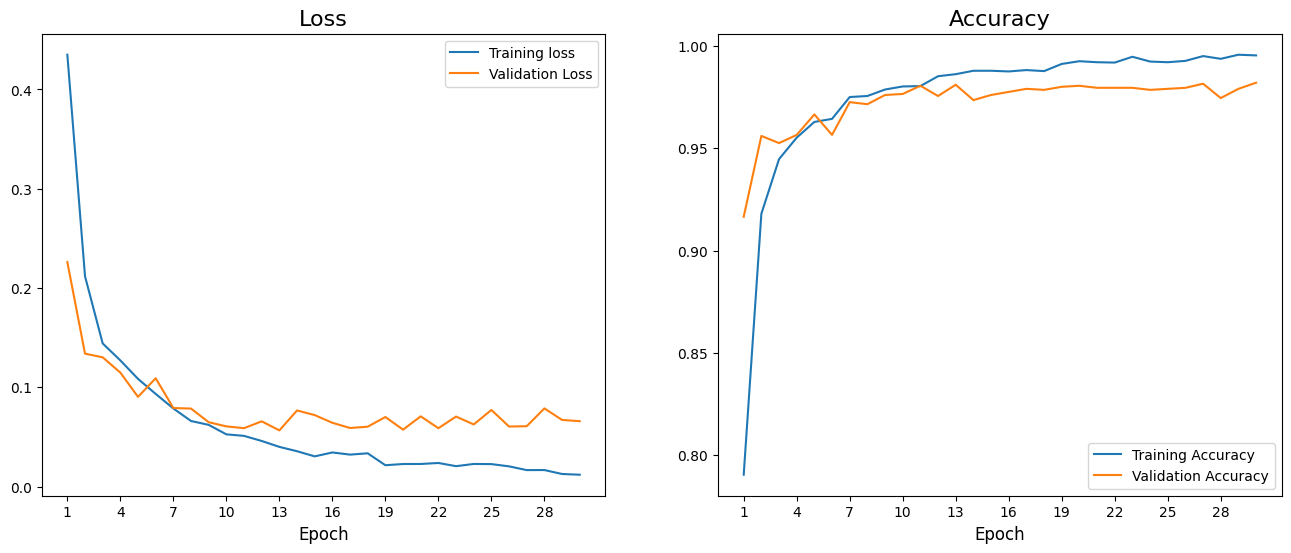

In [9]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,6))
title_fontsize = 16
axis_fontsize = 12

ax1.plot(range(1,epochs+1), history.history['loss'], label='Training loss')
ax1.plot(range(1,epochs+1), history.history['val_loss'], label='Validation Loss')
ax1.legend()
ax1.set_xticks(range(1,epochs+1,3))
ax1.set_title('Loss', fontsize=title_fontsize)
ax1.set_xlabel('Epoch', fontsize=axis_fontsize)

ax2.plot(range(1,epochs+1), history.history['accuracy'], label='Training Accuracy')
ax2.plot(range(1,epochs+1), history.history['val_accuracy'], label='Validation Accuracy')
ax2.legend()
ax2.set_xticks(range(1,epochs+1,3))
ax2.set_title('Accuracy', fontsize=title_fontsize)
ax2.set_xlabel('Epoch', fontsize=axis_fontsize);

The evaluation of the test data shows close results to the dev set as well, which is a good result. Overall, on a train-dev-test **60/20/20** split, this model has achieved an accuracy of **97.5%!**

In [10]:
score = model.evaluate(X_test, Y_test)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9876 - loss: 0.0445 
Test loss: 0.05194384977221489
Test accuracy: 0.9865000247955322


### Error Analysis
It is a good idea to examine what are examples of incorrectly labeled outputs to see if there is a certain characteristic of this input data that your model is performing poorly on. Below I will look a confusion matrix of the different outputs as well as a few of the incorrectly labeled results in the test set.

In [11]:
Y_pred = model.predict(X_test)
Y_pred_max = Y_pred.max(axis=1,keepdims=True)
Y_pred = (Y_pred_max == Y_pred).astype(int)
Y_test_labels = ohe.inverse_transform(Y_test)
Y_pred_labels = ohe.inverse_transform(Y_pred)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


,Shoe_pred,Sandal_pred
Shoe_true,99.052632,0.947368
Sandal_true,1.714286,98.285714


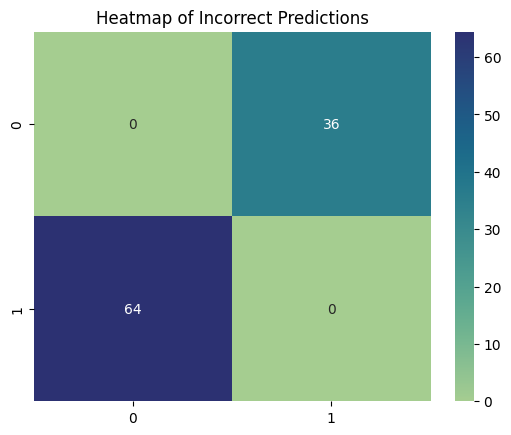

In [12]:
labels = labels=["Shoe", "Sandal"]
cm = confusion_matrix(Y_test_labels, Y_pred_labels, labels=labels, normalize='true') * 100



CM = pd.DataFrame(cm,
                  columns = [label+'_pred' for label in labels],
                  index = [label+'_true' for label in labels]).copy()

np.fill_diagonal(cm, 0)
cm = cm *100 / cm.sum()
sns.heatmap(cm, annot=True, cmap="crest")
plt.title('Heatmap of Incorrect Predictions')

CM

Over 60% of the incorrect guesses are coming from the model incorrectly predicting sandals as shoes. For further improvement to the model, we could focus on what is causing this discrepancy

In [13]:
prediction_df = pd.DataFrame(zip(Y_pred_labels[:,0], Y_test_labels[:,0]), columns=['Pred', 'True'])
prediction_df['Correct'] = prediction_df['Pred'] == prediction_df['True']
incorrect_predictions = list(prediction_df[prediction_df['Correct'] == False].index)

C:\Users\user\AppData\Local\Temp\ipykernel_17132\2590348222.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


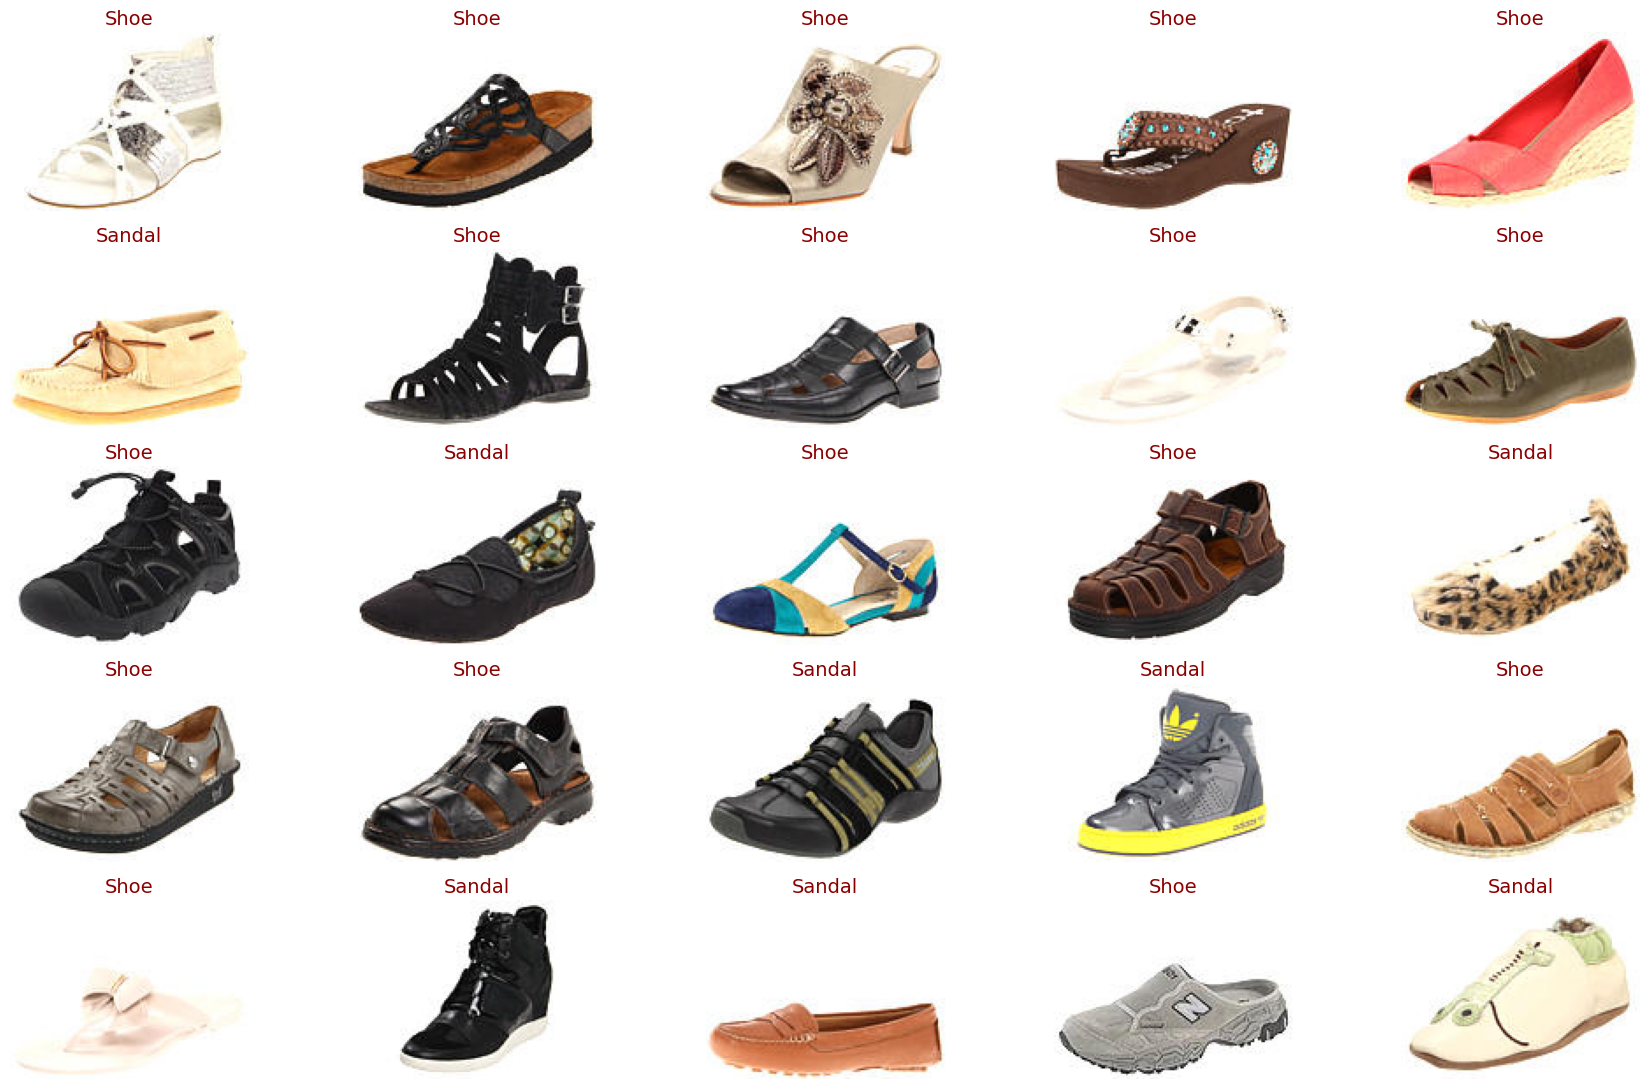

In [14]:
fig, axs = plt.subplots(5,5, figsize=[18,11])
for i, inpred in enumerate(incorrect_predictions[:25]):
    ax = axs[i//5, i%5]
    ax.imshow(X_test[inpred])
    ax.axis('off')
    ax.set_title(Y_pred_labels[inpred][0], fontsize=14, color="darkred")
    
fig.tight_layout()
fig.show()

### Error Analysis
Looking at this subsample of incorrectly predict labels, there seems to be a few trends:

- Incorrectly labeling sandals as shoes when there is a lot of material that covers the top of the foot or the soles are thicker.
- Incorrectly labeling as sandals when either design or laces has appears as thick stripes across top.